# 2-level system with oscillating detuning

## Imports
Start by importing the necessary packages

In [1]:
%load_ext autoreload
%autoreload 2

import joblib
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
plt.style.use("ggplot")
import numpy as np
import qutip
from sympy import Symbol

from toy_systems.couplings import ToyCoupling, ToyEnergy
from toy_systems.decays import ToyDecay
from toy_systems.hamiltonian import Hamiltonian
from toy_systems.quantum_system import QuantumSystem
from toy_systems.states import Basis, BasisState, ToyQuantumNumbers

## Define states
We start by defining the two states of the system: the ground state $|g\rangle$ and the excited $|e\rangle$.

In [2]:
g = BasisState(qn=ToyQuantumNumbers(label="g"))
e = BasisState(qn=ToyQuantumNumbers(label="e"))

# Print the states as a check
print(f"|g> = {g}")
print(f"|e> = {e}")

# Check that the states are orthogonal by taking inner product
print(f"<e|g> = {e @ g}")

|g> = |g>
|e> = |e>
<e|g> = 0


## Define basis
We use the two orthogonal states to define a basis as shown below. The indexing of the matrix and vector representations of operators is determined by the order of the states when generating the state

In [3]:
basis = Basis((g,e))
basis.print()

|0> = |g>
|1> = |e>


## Define energies
I'm going to define the system in the rotating frame so that the Hamiltonian doesn't have any quickly rotating terms of the form $e^{i\omega t}$. The detuning between the driving field and the natural frequency of the system is taken to be $ \Delta(t) = \Delta_0 + \frac{A}{2}\sin(\omega t) $.

In [4]:
E_g = ToyEnergy([g], 1/2, time_dep = "Delta0/2 +  A/2 * sin(omega*t)", time_args = {"Delta0":0, "omega":5, "A":1}) 
E_e = ToyEnergy([e], 1/2,  time_dep = "-Delta0/2 - A/2 * sin(omega*t)", time_args = {"Delta0":0, "omega":5, "A":1})

### Define coupling
Take the coupling field between the two states to be constant

In [5]:
Ω = Symbol('Omega') 
coupling = ToyCoupling(g, e, Ω/2)

## Define Hamiltonian
Now that we have the states, energies and couplings, we can define the Hamiltonian

In [6]:
H = Hamiltonian((E_g, E_e, coupling), basis)
display(H)

H =
[
[0.5, 0.5],
[0.5, 0.5]]

in basis Basis: name = None

## Define a QuantumSystem
The QuantumSystem object combines the basis, decays, and Hamiltonian to make setting parameters for time evolution using QuTiP more convenient.

In [7]:
# Define the system
system = QuantumSystem(
    basis=basis,
    couplings=[E_g, E_e, coupling],
    decays = []
)

# Get representations of the Hamiltonian and the decays that will be accepted by qutip
Hqobj, c_qobj = system.get_qobjs()

## Time-evolution using `QuTiP`
The `toy_systems` package is designed to take care of generating the Hamiltonian and collapse operators for the quantum system, and spit out a `qutip.QobjEVo`-object. The actual time-evolution is then taken care of by `qutip` (or something else if the user so desires).

In [8]:
# Get a pointer to the time-evolution arguments
args = Hqobj.args
print("Keys for setting arguments:")
print(f"args = {args}")

Keys for setting arguments:
args = {'Delta0': 0, 'omega': 5, 'A': 1, 'Omega': 1}


In [25]:
# Generate a Qobj representing the initial state
psi0 = (1*g).qobj(basis)

# Make operators for getting the probability of being in each state
P_g_op = qutip.Qobj((1*g).density_matrix(basis), type = "oper")
P_e_op = qutip.Qobj((1*e).density_matrix(basis), type = "oper")

# Pauli matrices for calculating components of Bloch vector
sx = qutip.sigmax()
sy = qutip.sigmay()
sz = qutip.sigmaz()


# Set the parameters for the system
args["Omega"] = 1 # The maximum value of the drive field Rabi rate (set to one so can use 1/Omega as unit of time)
args["Delta0"] = 0 # Constant part of detuning
args["A"] = 10 # Amplitude of detuning oscillations
args["omega"] = 5 # Frequency of detuning oscillations

# Times at which result is requested
times =  np.linspace(-10/np.abs(args["omega"]), 10/np.abs(args["omega"]), 3001) * 2* np.pi

# The solver used by qutip sometimes doesn't seem to notice that adiabatic passage is supposed to be happening, so reduce max step size to 
# mitigate this 
options = qutip.solver.Options(method = 'adams', nsteps=100000, max_step=1e0/np.abs(args["omega"]),)

# Setup a progress bar
pb = qutip.ui.progressbar.EnhancedTextProgressBar()

# Run the time-evolution
result = qutip.mesolve(Hqobj, psi0, times, c_ops = c_qobj, e_ops = [P_g_op, P_e_op, sx, sy, sz],
                      progress_bar=pb, options = options)

 Total run time:   1.68s*] Elapsed 1.68s / Remaining 00:00:00:00[******   25%           ] Elapsed 0.42s / Remaining 00:00:00:01[*********57%*          ] Elapsed 0.98s / Remaining 00:00:00:00[*********87%********   ] Elapsed 1.47s / Remaining 00:00:00:00


Plot the result:

Text(0, 0.5, 'Rabi rate')

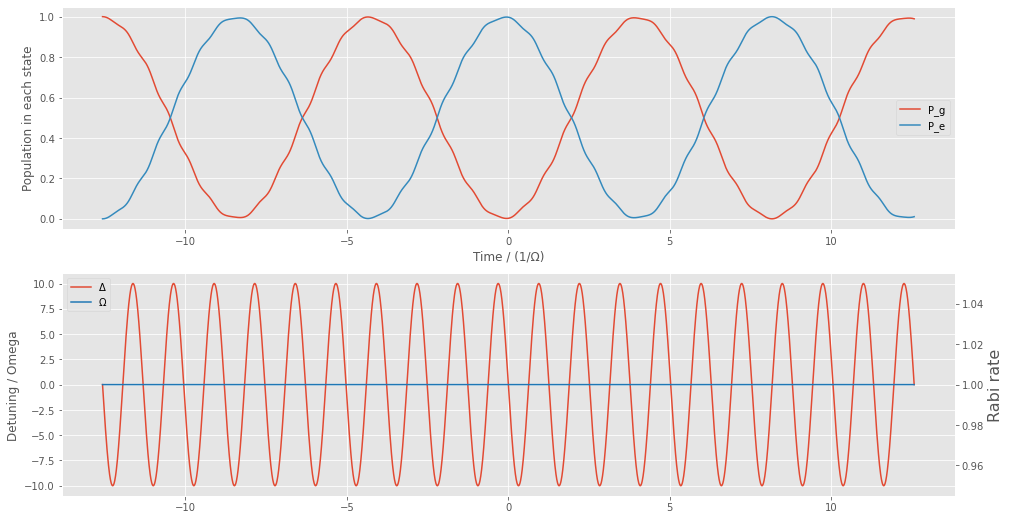

In [26]:
fig, (ax,ax2) = plt.subplots(2,1, figsize = (16,9))
ax.plot(times, result.expect[0], label = "P_g")
ax.plot(times, result.expect[1], label = "P_e")
ax.legend()
ax.set_xlabel("Time / (1/Ω)")
ax.set_ylabel("Population in each state")

# Plot the coupling strength and detuning also
ax2c = ax2.twinx()
ln1 = ax2.plot(times, E_e.eval(times, args) - E_g.eval(times, args) , label = "Δ")
ax2.set_ylabel('Detuning / Omega')
ln2 = coupling.plot_time_dep(times, args, ax = ax2c, label = 'Ω', c = 'tab:blue')
ax2c.grid(False)
ax2c.set_ylabel('')
ax2.legend(ln1+ln2, [l.get_label() for l in (ln1 + ln2)])
ax2c.set_ylabel('Rabi rate')

### Visualizing on Bloch sphere

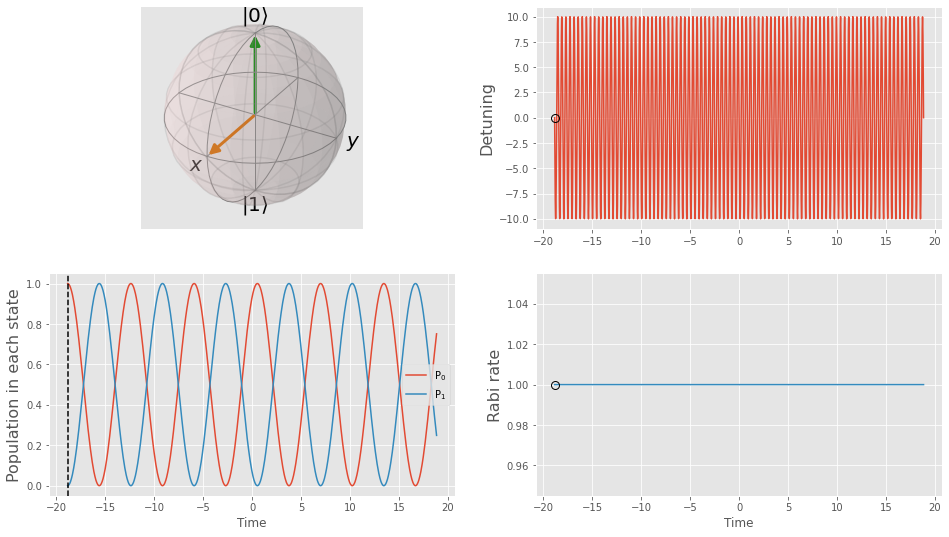

In [66]:
# Calculate components of Bloch vector
u = -result.expect[2]
v = result.expect[3]
w = result.expect[4]

# Calculate detuning and coupling strength
deltas = E_e.eval(times, time_args=args) - E_g.eval(times, time_args=args) 
Omegas = coupling.eval(times, time_args=args)
W_length = np.sqrt(deltas**2 + Omegas**2)


# Set up the bloch sphere
fig = plt.figure(figsize = (16, 9))
ax0 = fig.add_subplot(221, projection = '3d')
ax0.set_title('Bloch sphere', fontsize = 18)
b = qutip.Bloch(fig = fig, axes = ax0)
b.frame_width = 1
b.figsize = (16,16)

# Add initial Bloch vector and Rabi vector
b.add_vectors([np.array([u[0],v[0],w[0]]), np.array([Omegas[0], 0, deltas[0]])])
b.make_sphere()

# Set up plot of detuning 
ax1 = fig.add_subplot(222)
ax1.plot(times, deltas, label = "Δ")
ax1.set_ylabel('Detuning', fontsize = 16)
delta_marker = ax1.plot(times[0], deltas[0], marker = 'o', markersize=8, c = 'k', fillstyle='none')

# Set up plot of Rabi rate
ax2 = fig.add_subplot(224)
ax2.plot(times, Omegas, label = "Ω", c = 'C1')
ax2.set_ylabel('Rabi rate', fontsize = 16)
ax2.set_xlabel('Time')
rabi_marker = ax2.plot(times[0], Omegas[0], marker = 'o', markersize=8, c = 'k', fillstyle='none')

# Set up plot of populations
ax3 = fig.add_subplot(223)
ax3.plot(times, result.expect[0], label = r"P$_0$")
ax3.plot(times, result.expect[1], label = r"P$_1$")
ax3.set_ylabel('Population in each state', fontsize = 16)
vline = ax3.axvline(times[0], ls = '--', c = 'k')
ax3.set_xlabel('Time')
ax3.legend()


# Define function that generates frames for animation
def animate(i):
    b.clear()
    b.add_vectors([np.array([u[i],v[i],w[i]]), np.array([Omegas[i], 0, deltas[i]])/W_length[i]])
    i_start = np.max([0, i-100])
    b.add_points([u[i_start:i+1],v[i_start:i+1],w[i_start:i+1]])
    b.make_sphere()
    
    ax1.lines[1].remove()
    ax1.plot(times[i], deltas[i], marker = 'o', markersize=8, c = 'k', fillstyle='none')
    
    ax2.lines[1].remove()
    ax2.plot(times[i], Omegas[i], marker = 'o', markersize=8, c = 'k', fillstyle='none')
    
    ax3.lines[2].remove()
    ax3.axvline(times[i], ls = '--', c = 'k')


    return fig, (ax0, ax1, ax2, ax3)

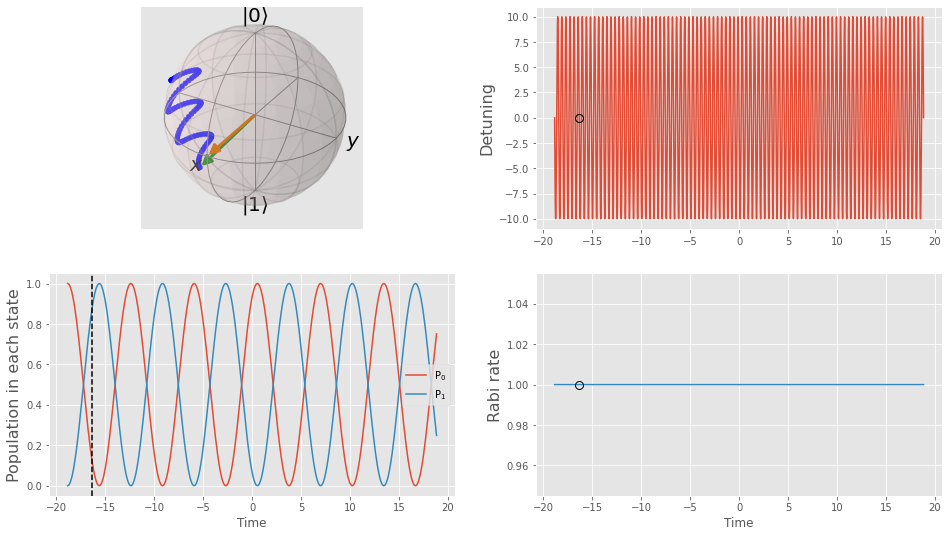

In [67]:
fig, _ = animate(200)
fig

In [40]:
# %%timeit
ani = animation.FuncAnimation(fig, animate, range(0,len(times),3), blit=False, repeat=False)
ani.save(f"oscillating_detuning_Delta0={args['Delta0']:.1f}_A={args['A']:.1f}_omega={args['omega']:.1f}.mp4", fps = 60)